# EN4 RAPID-OSNAP into T/S space

In [1]:
# import sys
# sys.path.append('/Users/dge105/Dropbox/Python_modules')

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates
import matplotlib
import datetime
import numpy as np
import cmocean
import pickle
import gsw
import seawater as sw
import numpy_groupies as npg
import cartopy.crs as ccrs
import os

from wmt import bin_3D_field_2D
from wmt import calc_tot_trans
from wmt import calc_grid_vol

from sklearn import preprocessing
from sklearn import mixture

from matplotlib import gridspec
from matplotlib import cm

from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.interpolate import griddata

In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

### Load EN4 data
Data extracted and saved within ~/Dropbox/work_general/datasets/RG_Argo/RG_Argo_extract.ipynb

In [3]:
dset_dir = os.path.expanduser('~/Dropbox/work_general/datasets/EN4/*.nc')
dset = xr.open_mfdataset(dset_dir)

# lon_limits = [20, 260]
lon_limits = [250, 360]
lat_limits = [25, 65]

dset = dset.sel(lat=dset.lat>=lat_limits[0], time=dset.time>np.datetime64('2004-01-01'))

# dset = dset.sel(lon=((dset.lon<lon_limits[0]) | (dset.lon>lon_limits[1])), lat=slice(lat_limits[0],lat_limits[1]), time=dset.time>np.datetime64('2004-01-01'))
# dset = dset.sel(lon=((dset.lon>lon_limits[0]) & (dset.lon<lon_limits[1])), lat=slice(lat_limits[0],lat_limits[1]), time=dset.time>np.datetime64('2004-01-01'))

m_dats = mdates.date2num(dset.time)

#### Load basin mask 

In [4]:
mask_dir = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods'
mask = xr.open_dataset(mask_dir)

# mask_nan = mask.basin.data
# mask_nan[mask_nan < 0] = np.nan

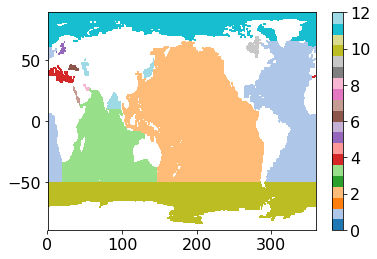

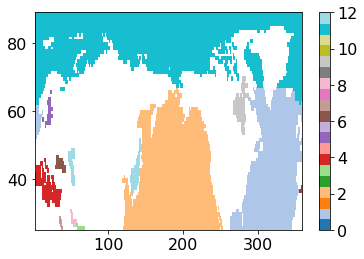

In [5]:
fig, ax = plt.subplots()
CS = ax.pcolormesh(mask.X, mask.Y, mask.basin[0, :, :], vmin=0, vmax=12, cmap=cm.tab20)
cbar = fig.colorbar(CS, ax=ax)

lon_g, lat_g = np.meshgrid(dset.lon.data, dset.lat.data)
lon_i = np.repeat(np.expand_dims(lon_g, axis=2), len(dset.depth.data), axis=2).flatten()
lat_i = np.repeat(np.expand_dims(lat_g, axis=2), len(dset.depth.data), axis=2).flatten()
dep_i = np.tile(dset.depth.data, (np.shape(lat_g)[0], np.shape(lat_g)[1], 1)).flatten()

interp_points = np.array([dep_i, lat_i, lon_i]).T
f = rgi((mask.Z.data, mask.Y.data, mask.X.data), mask.basin.data, method='nearest', bounds_error=False)
maski = f(interp_points)
maski = np.reshape(maski, (len(dset.lat.data), len(dset.lon.data), len(dset.depth.data)))
# maski = np.moveaxis(np.expand_dims(maski, axis=3), [0, 1, 2], [1, 2, 0])
maski = np.moveaxis(maski, [0, 1, 2], [1, 2, 0])

fig, ax = plt.subplots()
CS = ax.pcolormesh(dset.lon, dset.lat, maski[0, :, :], vmin=0, vmax=12, cmap=cm.tab20)
cbar = fig.colorbar(CS, ax=ax)

In [6]:
# Interpolate the mask so that it is on the same depth grid as EN4

# Our points onto which we interpolate
lon_g, lat_g = np.meshgrid(mask.X.data, mask.Y.data)
lon_i = np.repeat(np.expand_dims(lon_g, axis=2), len(dset.depth.data), axis=2).flatten() # Mask lon
lat_i = np.repeat(np.expand_dims(lat_g, axis=2), len(dset.depth.data), axis=2).flatten() # Mask lat
dep_i = np.tile(dset.depth.data, (np.shape(lat_g)[0], np.shape(lat_g)[1], 1)).flatten() # EN4 depth

interp_points = np.array([dep_i, lat_i, lon_i]).T
f = rgi((mask.Z.data, mask.Y.data, mask.X.data), mask.basin.data, method='nearest', bounds_error=False)
maski_en4_depth = f(interp_points)
maski_en4_depth = np.reshape(maski_en4_depth, (len(mask.Y.data), len(mask.X.data), len(dset.depth.data)))
# maski = np.moveaxis(np.expand_dims(maski, axis=3), [0, 1, 2], [1, 2, 0])
maski_en4_depth = np.moveaxis(maski_en4_depth, [0, 1, 2], [1, 2, 0])

In [7]:
temperature = np.moveaxis(dset.temperature.data.compute(), 0, -1)
lon_g_mask, lat_g_mask = np.meshgrid(mask.X.data, mask.Y.data)
lon_g_en4, lat_g_en4 = np.meshgrid(dset.lon.data, dset.lat.data)

mask_filled = np.zeros(maski.shape)

for ii in np.arange(0, len(dset.depth.data), 1):

    masknan_idx = ~np.isnan(maski_en4_depth[ii, :, :])
    nomask_idx = ~np.isnan(temperature[ii, :, :, 0]) & np.isnan(maski[ii, :, :])

    interp_points = np.array([lat_g_en4[nomask_idx], lon_g_en4[nomask_idx]]).T
    nomask_int = griddata((lat_g_mask[masknan_idx], lon_g_mask[masknan_idx]), maski_en4_depth[ii, :, :][masknan_idx], interp_points, method='nearest')

    mask_slice = maski[ii, :, :].copy()
    mask_slice[nomask_idx] = nomask_int.copy()

    mask_filled[ii, :, :] = mask_slice.copy()

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


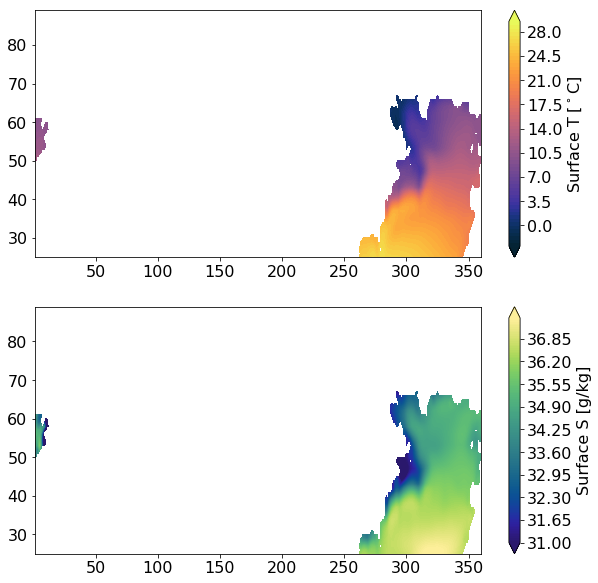

In [8]:
fig = plt.figure(figsize=(10,10))
ax1, ax2 = fig.subplots(2,1)

T_levels = np.arange(-3, 30, 0.5) 
S_levels = np.arange(31, 37.5, 0.05) 

temperature = np.moveaxis(dset.temperature.data.compute(), 0, -1)
temperature[mask_filled != 1] = np.nan

salinity = np.moveaxis(dset.salinity.data.compute(), 0, -1)
salinity[mask_filled != 1] = np.nan

CS_T = ax1.contourf(dset.lon, dset.lat, np.nanmean(temperature[0, :, :, :], axis=2) - 273.15,
           T_levels, cmap=cmocean.cm.thermal, extend='both')

CS_S = ax2.contourf(dset.lon, dset.lat, np.nanmean(salinity[0, :, :, :], axis=2),
           S_levels, cmap=cmocean.cm.haline, extend='both')

cbarT = fig.colorbar(CS_T, ax=ax1)
cbarT.ax.set_ylabel('Surface T [$^\circ$C]')

cbarS = fig.colorbar(CS_S, ax=ax2)
cbarS.ax.set_ylabel('Surface S [g/kg]')

plt.savefig(os.path.expanduser('~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/EN4_RAPID2OSNAP_surfTS.png'), dpi=300, bbox_inches='tight')


In [9]:
lat = dset.lat.data
lon = dset.lon.data
dep = dset.depth.data
max_dep = dep[-1] + np.diff(dep)[-1]

gr_vol = calc_grid_vol(lon, lat, dep, 'm', 0, max_dep)

In [10]:
lon_g, lat_g = np.meshgrid(lon, lat)

lon_g = np.moveaxis(np.repeat(np.expand_dims(lon_g, axis=2), len(dep), axis=2), [2], [0])
lat_g = np.moveaxis(np.repeat(np.expand_dims(lat_g, axis=2), len(dep), axis=2), [2], [0])
dep_g = np.moveaxis(np.tile(dep, (np.shape(lat_g)[2], np.shape(lat_g)[1], 1)), [0, 1, 2], [2, 1, 0])


### Loop through each time-step

In [11]:
dS = 0.025
dT = 0.25
# S_bin = np.arange(32, 38 + dS, dS)
S_bin = np.arange(25, 40 + dS, dS)
T_bin = np.arange(-3, 32 + dT, dT)
S_bini = S_bin[0:-1] + dS/2
T_bini = T_bin[0:-1] + dT/2 
S_binii = S_bini[0:-1] + dS/2
T_binii = T_bini[0:-1] + dT/2 

In [12]:
lon_g, lat_g = np.meshgrid(dset.lon, dset.lat)
lon_g = np.repeat(np.expand_dims(lon_g, axis=0), len(dset.depth), axis=0)
lat_g = np.repeat(np.expand_dims(lat_g, axis=0), len(dset.depth), axis=0)
pres_g = np.moveaxis(np.tile(dset.depth, (np.shape(lon_g)[2], np.shape(lon_g)[1], 1)), [0, 1, 2], [2, 1, 0])

ts_vol = np.zeros((len(T_bini), len(S_bini), np.shape(dset.temperature)[0]))
ts_lat = np.zeros((len(T_bini), len(S_bini), np.shape(dset.temperature)[0]))
ts_lon = np.zeros((len(T_bini), len(S_bini), np.shape(dset.temperature)[0]))
ts_dep = np.zeros((len(T_bini), len(S_bini), np.shape(dset.temperature)[0]))

bin_edge1 = T_bin
bin_edge2 = S_bin
# func = 'sum'

for ii in np.arange(0, np.shape(dset.temperature)[0], 1):

    SA = gsw.SA_from_SP(salinity[:, :, :, ii], pres_g, lon_g, lat_g)
    CT = gsw.CT_from_t(SA, temperature[:, :, :, ii] - 273.15, pres_g)

    bin1_3D = CT
    bin2_3D = SA
    var_3D = gr_vol

    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, 'sum')
    ts_vol[:, :, ii] = out[0]
    
    var_3D = lon_g
    
    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, 'mean')
    ts_lon[:, :, ii] = out[0]

    var_3D = lat_g
    
    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, 'mean')
    ts_lat[:, :, ii] = out[0]
    
    var_3D = dep_g
    
    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, 'mean')
    ts_dep[:, :, ii] = out[0]
    
# ts_vol[ts_vol == 0] = np.nan
    
ts_vol = {'ts_vol': ts_vol, 'S_bini': S_bini, 'T_bini': T_bini, 'S_binii': S_binii, 'T_binii': T_binii, 'time': m_dats}
    

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


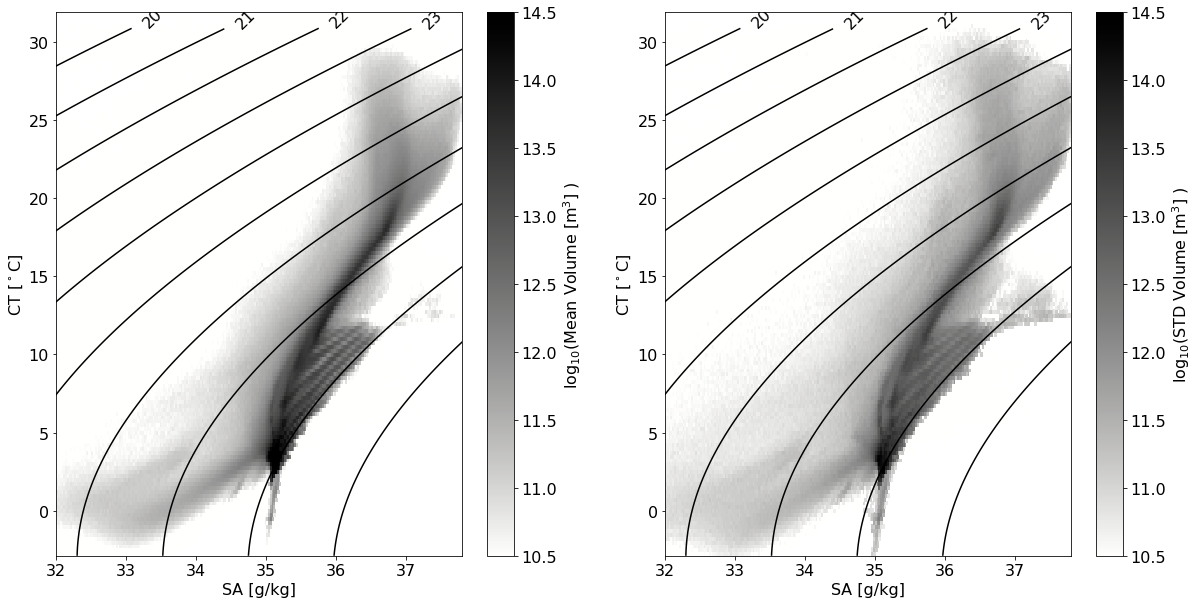

In [13]:
ts_vol_zero = ts_vol['ts_vol']
ts_vol_zero[np.isnan(ts_vol_zero)] = 0

S_g, T_g = np.meshgrid(S_bini, T_bini)
dens_g = sw.dens0(S_g,T_g) - 1000

c_lim = (10.5, 14.5)
levels = np.arange(c_lim[0], c_lim[1] + 0.1, 0.1)
fig = plt.figure(figsize=(20, 10))
ax1, ax2 = fig.subplots(1, 2)

CS1 = ax1.pcolormesh(S_bini, T_bini, np.log10(np.nanmean(ts_vol_zero, axis=2) ),  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
CS_dens = ax1.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax1.clabel(CS_dens, fmt='%2.0f')

CS2 = ax2.pcolormesh(S_bini, T_bini, np.log10(np.nanstd(ts_vol_zero, axis=2) ),  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
CS_dens = ax2.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax2.clabel(CS_dens, fmt='%2.0f')

cbar = fig.colorbar(CS1, ax=ax1)
cbar.ax.set_ylabel('log$_{10}$(Mean Volume [m$^3$] )')

cbar = fig.colorbar(CS2, ax=ax2)
cbar.ax.set_ylabel('log$_{10}$(STD Volume [m$^3$] )')

ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('CT [$^\circ$C]')

ax1.set_xlabel('SA [g/kg]')
ax2.set_xlabel('SA [g/kg]')

ax1.set_xlim((32, 37.8))
ax2.set_xlim((32, 37.8))

plt.savefig(os.path.expanduser('~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/EN4_RAPID2OSNAP_ts_vol_mean_std.png'), dpi=300, bbox_inches='tight')


/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


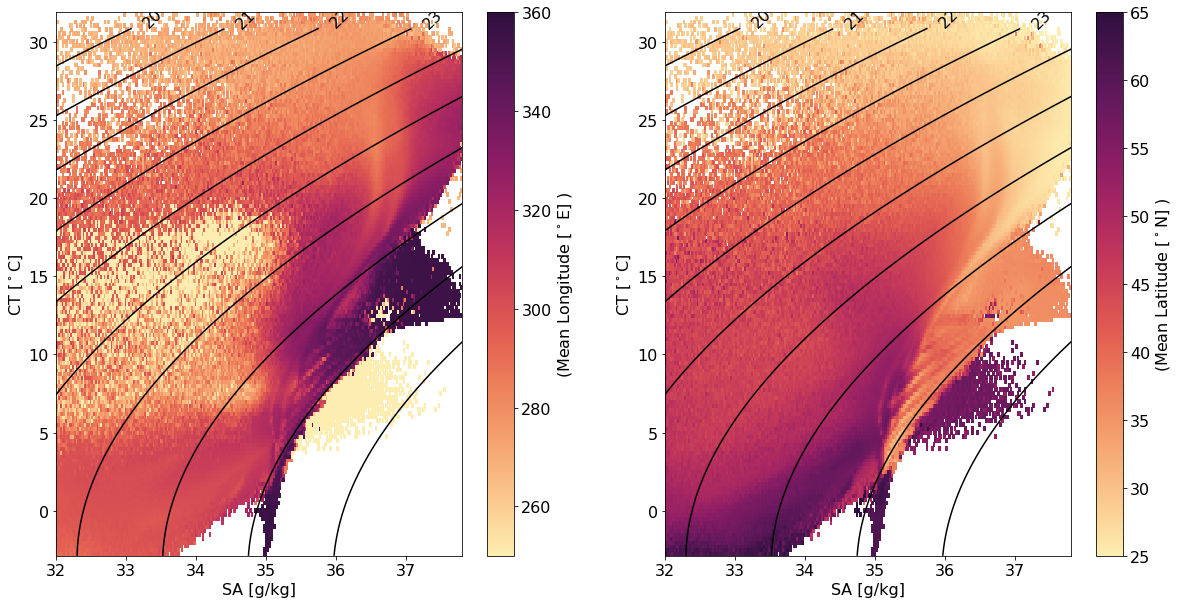

In [14]:
ts_vol_zero = ts_vol['ts_vol']
ts_vol_zero[np.isnan(ts_vol_zero)] = 0

S_g, T_g = np.meshgrid(S_bini, T_bini)
dens_g = sw.dens0(S_g,T_g) - 1000

# levels = np.arange(c_lim[0], c_lim[1] + 0.1, 0.1)
fig = plt.figure(figsize=(20, 10))
ax1, ax2 = fig.subplots(1, 2)

CS1 = ax1.pcolormesh(S_bini, T_bini, (np.nanmean(ts_lon, axis=2) ),  vmin=lon_limits[0], vmax=lon_limits[1], cmap=cmocean.cm.matter, shading='flat')
CS_dens = ax1.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax1.clabel(CS_dens, fmt='%2.0f')

CS2 = ax2.pcolormesh(S_bini, T_bini, (np.nanmean(ts_lat, axis=2) ),  vmin=lat_limits[0], vmax=lat_limits[1], cmap=cmocean.cm.matter, shading='flat')
CS_dens = ax2.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax2.clabel(CS_dens, fmt='%2.0f')

cbar = fig.colorbar(CS1, ax=ax1)
cbar.ax.set_ylabel('(Mean Longitude [$^\circ$E] )')

cbar = fig.colorbar(CS2, ax=ax2)
cbar.ax.set_ylabel('(Mean Latitude [$^\circ$N] )')

ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('CT [$^\circ$C]')

ax1.set_xlabel('SA [g/kg]')
ax2.set_xlabel('SA [g/kg]')

ax1.set_xlim((32, 37.8))
ax2.set_xlim((32, 37.8))

plt.savefig(os.path.expanduser('~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/EN4_RAPID2OSNAP_ts_lon_lat.png'), dpi=300, bbox_inches='tight')


### Calculate diathermal and diahaline transformations

In [49]:
# Difference calculated as n - n-1
# G_t = np.zeros((len(ts_vol['T_bini']) - 1, len(ts_vol['S_bini']), len(ts_vol['time']) ) )
# G_ti = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']), len(ts_vol['time']) ) )

# G_s = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']) - 1, len(ts_vol['time']) ) )
# G_si = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']), len(ts_vol['time']) ) )

# dvol = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']), len(ts_vol['time']) ) )

# tot_trans = {'G_t': G_t.copy(), 'G_s': G_s.copy(), 'G_ti': G_ti.copy(), 'G_si': G_si.copy(), 'dvol': dvol, 'time': ts_vol['time']}

# dt = 30 * 24 * 60 * 60

# dens_limit = (20, 29.5)
# dens_idx = (dens_g < dens_limit[0]) | (dens_g > dens_limit[1])

# ts_vol['ts_vol'][np.repeat(np.expand_dims(dens_idx, axis=2), len(ts_vol['time']), axis=2)] = 0

# for ii in np.arange(0, len(ts_vol['time']), 1):

#     ts_vol_start = ts_vol['ts_vol'][:, :, ii]
#     ts_vol_end = ts_vol['ts_vol'][:, :, ii+1]

#     out = calc_tot_trans(ts_vol_start, ts_vol_end, dt, ts_vol['S_bini'], ts_vol['T_bini'], ts_vol['S_binii'], ts_vol['T_binii'])

#     tot_trans['G_t'][:, :, ii] = out['G_t']
#     tot_trans['G_ti'][:, :, ii] = out['G_ti']
#     tot_trans['G_s'][:, :, ii] = out['G_s']
#     tot_trans['G_si'][:, :, ii] = out['G_si']
#     tot_trans['dvol'][:, :, ii] = out['dvol']

############

# Central difference
G_t = np.zeros((len(ts_vol['T_bini']) - 1, len(ts_vol['S_bini']), len(ts_vol['time']) - 2 ) )
G_ti = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']), len(ts_vol['time']) - 2 ) )

G_s = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']) - 1, len(ts_vol['time']) - 2 ) )
G_si = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']), len(ts_vol['time']) - 2 ) )

dvol = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']), len(ts_vol['time']) - 2 ) )

tot_trans = {'G_t': G_t.copy(), 'G_s': G_s.copy(), 'G_ti': G_ti.copy(), 'G_si': G_si.copy(), 'dvol': dvol, 'time': ts_vol['time'][1:-1]}

dt = (30 * 24 * 60 * 60) * 2

dens_limit = (20, 29.5)
dens_idx = (dens_g < dens_limit[0]) | (dens_g > dens_limit[1])

# ts_vol_plus1 = np.dstack((ts_vol['ts_vol'][: , : , 1:], np.zeros(np.shape(ts_vol['ts_vol'])[:-1])))
# ts_vol_minus1 = np.dstack((np.zeros(np.shape(ts_vol['ts_vol'])[:-1]), ts_vol['ts_vol'][: , : , :-1]))

# ts_vol_plus1[np.repeat(np.expand_dims(dens_idx, axis=2), len(ts_vol['time']), axis=2)] = 0
# ts_vol_minus1[np.repeat(np.expand_dims(dens_idx, axis=2), len(ts_vol['time']), axis=2)] = 0

ts_vol_plus1 = ts_vol['ts_vol'][: , : , 2:]
ts_vol_minus1 = ts_vol['ts_vol'][: , : , :-2]

ts_vol_plus1[np.repeat(np.expand_dims(dens_idx, axis=2), len(ts_vol['time']) - 2, axis=2)] = 0
ts_vol_minus1[np.repeat(np.expand_dims(dens_idx, axis=2), len(ts_vol['time']) - 2, axis=2)] = 0

for ii in np.arange(0, np.shape(ts_vol_plus1)[2], 1):

    ts_vol_start = ts_vol_minus1[:, :, ii]
    ts_vol_end = ts_vol_plus1[:, :, ii]

    out = calc_tot_trans(ts_vol_start, ts_vol_end, dt, ts_vol['S_bini'], ts_vol['T_bini'], ts_vol['S_binii'], ts_vol['T_binii'])

    tot_trans['G_t'][:, :, ii] = out['G_t']
    tot_trans['G_ti'][:, :, ii] = out['G_ti']
    tot_trans['G_s'][:, :, ii] = out['G_s']
    tot_trans['G_si'][:, :, ii] = out['G_si']
    tot_trans['dvol'][:, :, ii] = out['dvol']


### Save using pickle

To load use the following: </br>

```python
with open(fname, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    ts_vol = pickle.load(f)
```

In [55]:
outfile = '/Users/dgwynevans/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/EN4_TS_dS_{:2.3f}_dT_{:2.2f}_dens_lim_{:2.2f}_{:2.2f}_lat_{:2.0f}_{:2.0f}.pickle'.format(\
dS, dT, dens_limit[0], dens_limit[1], lat_limits[0], lat_limits[1])

with open(outfile, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump((tot_trans, ts_vol), f, pickle.HIGHEST_PROTOCOL)

In [33]:
# dens_limit = (20, 29.5)
# lon_limits = [20, 260]
# lat_limits = [25, 60]
# # lon_limits = [250, 360]
# # lat_limits = [25, 65]

# outfile = '/Users/dgwynevans/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/EN4_TS_dS_{:2.3f}_dT_{:2.2f}_dens_lim_{:2.2f}_{:2.2f}_lat_{:2.0f}_{:2.0f}.pickle'.format(\
# dS, dT, dens_limit[0], dens_limit[1], lat_limits[0], lat_limits[1])

# with open(outfile, 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     out = pickle.load(f)

# tot_trans = out[0]
# ts_vol = out[1]

In [34]:
def dateticker(ax):
    loc = mdates.AutoDateLocator()
    tick_format = mdates.AutoDateFormatter(loc)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(tick_format)

In [23]:
def calc_mm_an_3dims(Var, datvec):
    Var_mm = np.zeros((np.shape(Var)[0], np.shape(Var)[1], 12))
    Var_mm_an = np.zeros(np.shape(Var))

    for ii in np.arange(1, 13, 1):
        Var_mm[:, :, ii - 1] = np.nanmean(Var[:, :, datvec[:, 1] == ii], axis=2)

        Var_mm_an[:, :, datvec[:, 1] == ii] = Var[:, :, datvec[:, 1] == ii] - np.expand_dims(Var_mm[:, :, ii - 1], axis=2)

    return (Var_mm, Var_mm_an)

def calc_mm_an_2dims(Var, datvec):
    Var_mm = np.zeros((np.shape(Var)[0], 12))
    Var_mm_an = np.zeros(np.shape(Var))

    for ii in np.arange(1, 13, 1):
        Var_mm[:, ii - 1] = np.nanmean(Var[:, datvec[:, 1] == ii], axis=1)

        Var_mm_an[:, datvec[:, 1] == ii] = Var[:, datvec[:, 1] == ii] - np.expand_dims(Var_mm[:, ii - 1], axis=1)

    return (Var_mm, Var_mm_an)

Text(0,0.5,'SA [g/kg]')

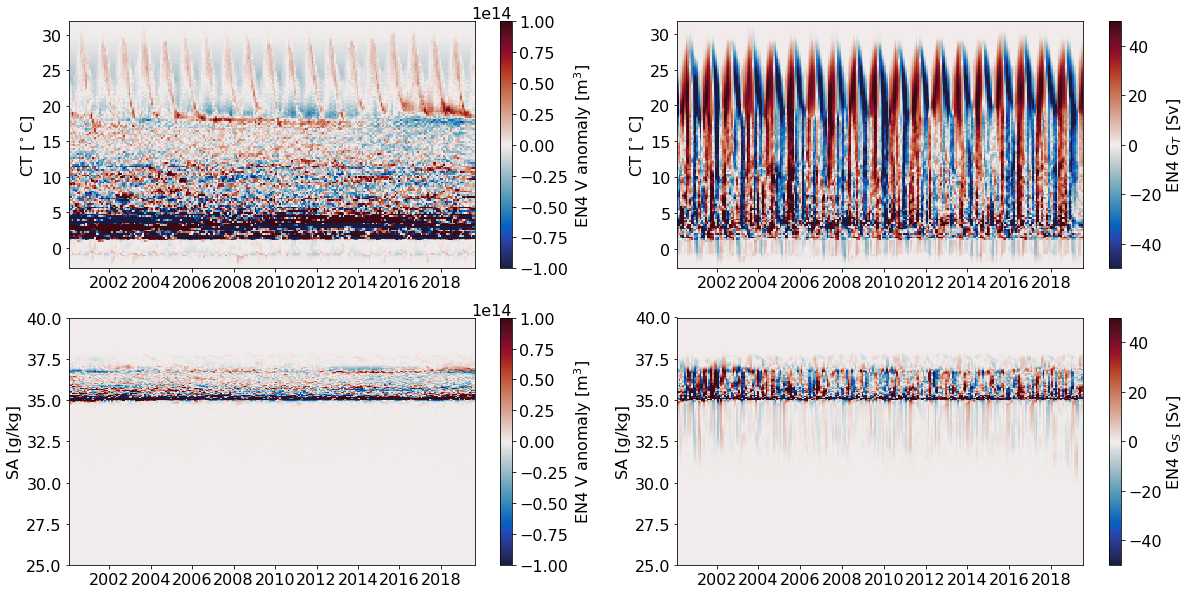

In [50]:
# vol_time_anom_t = np.nansum(ts_vol_mm_an, axis=1)
# vol_time_anom_s = np.nansum(ts_vol_mm_an, axis=0)

vol_time_anom_t = np.nansum(ts_vol['ts_vol'] - np.expand_dims(np.nanmean(ts_vol['ts_vol'], axis=2), axis=2), axis=1)
vol_time_anom_s = np.nansum(ts_vol['ts_vol'] - np.expand_dims(np.nanmean(ts_vol['ts_vol'], axis=2), axis=2), axis=0)

G_t_time_anom_t = np.nansum(tot_trans['G_t'] - np.expand_dims(np.nanmean(tot_trans['G_t'], axis=2), axis=2), axis=1)
G_s_time_anom_s = np.nansum(tot_trans['G_s'] - np.expand_dims(np.nanmean(tot_trans['G_s'], axis=2), axis=2), axis=0)

G_t_t = np.nansum(tot_trans['G_t'], axis=1)
G_s_s = np.nansum(tot_trans['G_s'], axis=0)

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(2, 2)
ax1 = ax[0, 0]
ax2 = ax[1, 0]
ax3 = ax[0, 1]
ax4 = ax[1, 1]

vol_lim = (-1e14, 1e14)
cs_t = ax1.pcolormesh(ts_vol['time'], ts_vol['T_bini'], vol_time_anom_t, vmin=vol_lim[0], vmax=vol_lim[1], cmap=cmocean.cm.balance)
dateticker(ax1)
cs_s = ax2.pcolormesh(ts_vol['time'], ts_vol['S_bini'], vol_time_anom_s, vmin=vol_lim[0], vmax=vol_lim[1], cmap=cmocean.cm.balance)
dateticker(ax2)

cbar = fig.colorbar(cs_t, ax=ax1)
cbar.ax.set_ylabel('EN4 V anomaly [m$^3$]')

cbar = fig.colorbar(cs_s, ax=ax2)
cbar.ax.set_ylabel('EN4 V anomaly [m$^3$]')
ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('SA [g/kg]')

trans_lim = (-50, 50)
cs_t = ax3.pcolormesh(tot_trans['time'], ts_vol['T_binii'], G_t_t / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)
dateticker(ax3)
cs_s = ax4.pcolormesh(tot_trans['time'], ts_vol['S_binii'], G_s_s / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)
dateticker(ax4)

cbar = fig.colorbar(cs_t, ax=ax3)
cbar.ax.set_ylabel('EN4 G$_T$ [Sv]')

cbar = fig.colorbar(cs_s, ax=ax4)
cbar.ax.set_ylabel('EN4 G$_S$ [Sv]')
ax3.set_ylabel('CT [$^\circ$C]')
ax4.set_ylabel('SA [g/kg]')

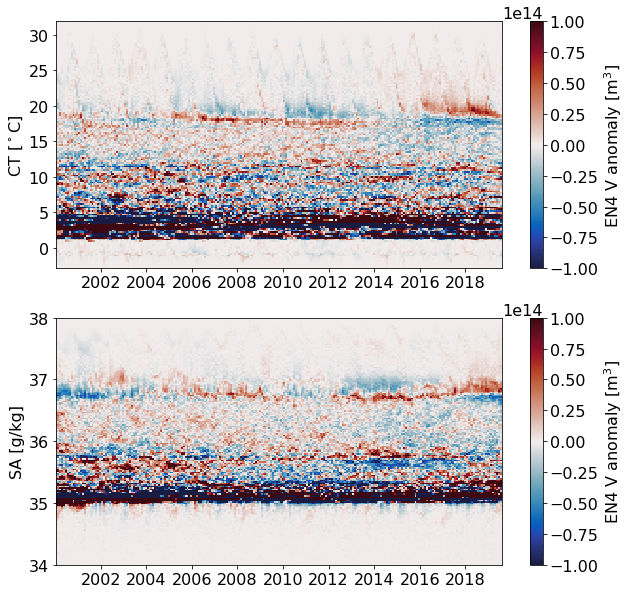

In [36]:
datvec = np.zeros((len(ts_vol['time']), 3))
for ii in np.arange(0, len(ts_vol['time']), 1):
    datvec[ii, 0] = mdates.num2date(ts_vol['time'])[ii].year
    datvec[ii, 1] = mdates.num2date(ts_vol['time'])[ii].month
    datvec[ii, 2] = mdates.num2date(ts_vol['time'])[ii].day

ts_vol_mm, ts_vol_mm_an = calc_mm_an_3dims(ts_vol['ts_vol'], datvec)

# vol_time_anom_t = np.nansum(ts_vol['ts_vol'] - np.expand_dims(np.nanmean(ts_vol['ts_vol'], axis=2), axis=2), axis=1)
# vol_time_anom_s = np.nansum(ts_vol['ts_vol'] - np.expand_dims(np.nanmean(ts_vol['ts_vol'], axis=2), axis=2), axis=0)

vol_time_anom_t = np.nansum(ts_vol_mm_an, axis=1)
vol_time_anom_s = np.nansum(ts_vol_mm_an, axis=0)

fig = plt.figure(figsize=(10,10))
ax = fig.subplots(2, 1)
ax1 = ax[0]
ax2 = ax[1]

vol_lim = (-1e14, 1e14)
cs_t = ax1.pcolormesh(ts_vol['time'], ts_vol['T_bini'], vol_time_anom_t, vmin=vol_lim[0], vmax=vol_lim[1], cmap=cmocean.cm.balance)
dateticker(ax1)
cs_s = ax2.pcolormesh(ts_vol['time'], ts_vol['S_bini'], vol_time_anom_s, vmin=vol_lim[0], vmax=vol_lim[1], cmap=cmocean.cm.balance)
dateticker(ax2)

cbar = fig.colorbar(cs_t, ax=ax1)
cbar.ax.set_ylabel('EN4 V anomaly [m$^3$]')

cbar = fig.colorbar(cs_s, ax=ax2)
cbar.ax.set_ylabel('EN4 V anomaly [m$^3$]')

ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('SA [g/kg]')

ax2.set_ylim((34, 38))

plt.savefig(os.path.expanduser('~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/EN4_RAPID2OSNAP_T_vol_anomaly.png'), dpi=300, bbox_inches='tight')


In [51]:
datvec = np.zeros((len(tot_trans['time']), 3))
for ii in np.arange(0, len(tot_trans['time']), 1):
    datvec[ii, 0] = mdates.num2date(tot_trans['time'])[ii].year
    datvec[ii, 1] = mdates.num2date(tot_trans['time'])[ii].month
    datvec[ii, 2] = mdates.num2date(tot_trans['time'])[ii].day
    
G_t = tot_trans['G_t'][: , :, 1:-1]
G_s = tot_trans['G_s'][: , :, 1:-1]

G_t_mm = np.zeros((np.shape(tot_trans['G_t'])[0], np.shape(tot_trans['G_t'])[1], 12))
G_s_mm = np.zeros((np.shape(tot_trans['G_s'])[0], np.shape(tot_trans['G_s'])[1], 12))
G_t_mm_an = np.zeros(np.shape(G_t))
G_s_mm_an = np.zeros(np.shape(G_s))

for ii in np.arange(1, 13, 1):
    G_t_mm[:, :, ii - 1] = np.nanmean(G_t[:, :, datvec[1:-1, 1] == ii], axis=2)
    G_s_mm[:, :, ii - 1] = np.nanmean(G_s[:, :, datvec[1:-1, 1] == ii], axis=2)
    
    G_t_mm_an[:, :, datvec[1:-1, 1] == ii] = G_t[:, :, datvec[1:-1, 1] == ii] - np.expand_dims(G_t_mm[:, :, ii - 1], axis=2)    
    G_s_mm_an[:, :, datvec[1:-1, 1] == ii] = G_s[:, :, datvec[1:-1, 1] == ii] - np.expand_dims(G_s_mm[:, :, ii - 1], axis=2)

Text(0,0.5,'SA [g/kg]')

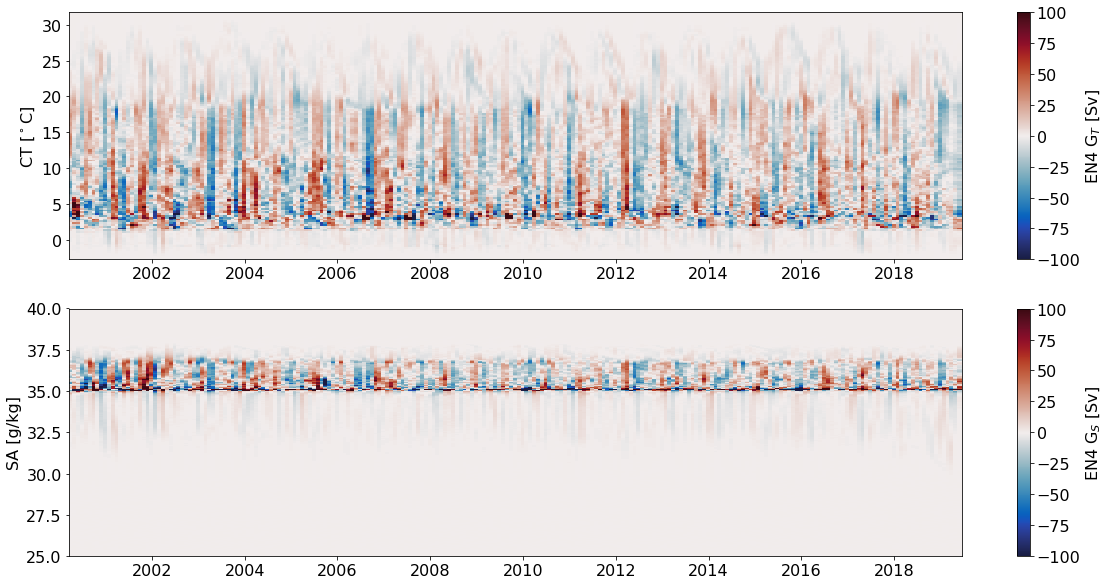

In [53]:
G_t_mm_an_t = np.nansum(G_t_mm_an, axis=1)
G_s_mm_an_s = np.nansum(G_s_mm_an, axis=0)

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(2, 1)
ax1 = ax[0]
ax2 = ax[1]


trans_lim = (-100, 100)
cs_t = ax1.pcolormesh(tot_trans['time'][1:-1], ts_vol['T_binii'], G_t_mm_an_t / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)
dateticker(ax1)
cs_s = ax2.pcolormesh(tot_trans['time'][1:-1], ts_vol['S_binii'], G_s_mm_an_s / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)
dateticker(ax2)

cbar = fig.colorbar(cs_t, ax=ax1)
cbar.ax.set_ylabel('EN4 G$_T$ [Sv]')

cbar = fig.colorbar(cs_s, ax=ax2)
cbar.ax.set_ylabel('EN4 G$_S$ [Sv]')
ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('SA [g/kg]')